In [19]:
#Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import pandas as pd
from keras import backend as K
from keras.losses import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Load database from https://mrv.emsa.europa.eu/#public/emission-report
data20=pd.read_excel("2020-v25-01082021-EU MRV Publication of information.xlsx",index_col=0,skiprows=2)
data20=data20.rename(columns={"Time spent at sea [hours]": "Total time spent at sea [hours]", "Annual Time spent at sea [hours]": "Annual Total time spent at sea [hours]"})

In [3]:
#Removing ships that didn't travel
data20['Annual average Fuel consumption per distance [kg / n mile]'] = pd.to_numeric(data20['Annual average Fuel consumption per distance [kg / n mile]'], errors='coerce')
data20=data20.dropna(subset=["Annual average Fuel consumption per distance [kg / n mile]"])


In [4]:
# Convert technical efficiency to numeric data
data20["Technical efficiency (gCO₂/t·nm)"]=data20["Technical efficiency"].str.replace(r"\D+",'')
data20['Technical efficiency (gCO₂/t·nm)'] = pd.to_numeric(data20['Technical efficiency (gCO₂/t·nm)'], errors='coerce')
data20=data20.dropna(subset=["Technical efficiency (gCO₂/t·nm)"])
data20['Technical efficiency (gCO₂/t·nm)']=data20['Technical efficiency (gCO₂/t·nm)']/100

In [5]:
#Calculating distance of ships
data20["Distance travelled(n miles)"]=(data20["Total fuel consumption [m tonnes]"]/data20["Annual average Fuel consumption per distance [kg / n mile]"])*1000

In [6]:
#Create subset containing columns to be used
data=data20[["Total CO₂ emissions [m tonnes]","Ship type","Technical efficiency (gCO₂/t·nm)","Distance travelled(n miles)","Total time spent at sea [hours]"]]
data.head()

,Total CO₂ emissions [m tonnes],Ship type,Technical efficiency (gCO₂/t·nm),Distance travelled(n miles),Total time spent at sea [hours]
IMO Number,,,,,
6602898,2985.13,Passenger ship,31.73,7203.528432,488.87
6703343,706.78,Other ship types,57.84,5538.650307,603.00
7037806,4947.88,Ro-pax ship,1.94,14849.610315,995.00
7043843,8416.81,Ro-ro ship,48.71,40842.097075,3109.20
7128332,13137.92,Ro-pax ship,9.29,47931.440443,3619.00


In [7]:
#Convert Ship type to numeric data 
data = pd.get_dummies(data, columns=['Ship type'], prefix='', prefix_sep='')

In [8]:
data.head()

,Total CO₂ emissions [m tonnes],Technical efficiency (gCO₂/t·nm),Distance travelled(n miles),Total time spent at sea [hours],Bulk carrier,Chemical tanker,Combination carrier,Container ship,Container/ro-ro cargo ship,Gas carrier,General cargo ship,LNG carrier,Oil tanker,Other ship types,Passenger ship,Refrigerated cargo carrier,Ro-pax ship,Ro-ro ship,Vehicle carrier
IMO Number,,,,,,,,,,,,,,,,,,,
6602898,2985.13,31.73,7203.528432,488.87,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6703343,706.78,57.84,5538.650307,603.00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7037806,4947.88,1.94,14849.610315,995.00,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7043843,8416.81,48.71,40842.097075,3109.20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7128332,13137.92,9.29,47931.440443,3619.00,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [9]:
#Create training and test dataset
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

In [10]:
#Seperate the target label, total CO2, from the features
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Total CO₂ emissions [m tonnes]')
test_labels = test_features.pop('Total CO₂ emissions [m tonnes]')

In [11]:
#Normalise the features
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [20]:
#Build deep neural network model
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

def build_and_compile_model(norm):
    model = keras.Sequential([norm,layers.Dense(64, activation='relu'),layers.Dense(64, activation='relu'),layers.Dense(1) ])
    model.compile(loss=root_mean_squared_error,optimizer=tf.keras.optimizers.Adam(0.001))
    return model

dnn_model = build_and_compile_model(normalizer)


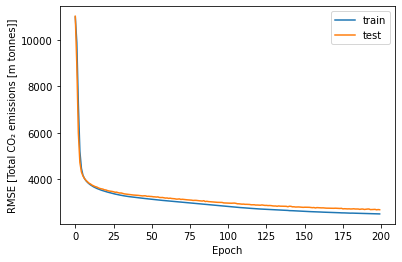

In [21]:
#Fit and and test model
def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE [Total CO₂ emissions [m tonnes]]')
    plt.legend()
    plt.grid(False)

history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,batch_size = 32,
    verbose=0, epochs=200)
plot_loss(history)

In [23]:
#Evaluate the model
test_results = {}
test_results['DNNmodel'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['RMSE [Total CO₂ emissions [m tonnes]]']).T

,RMSE [Total CO₂ emissions [m tonnes]]
DNNmodel,2579.137695


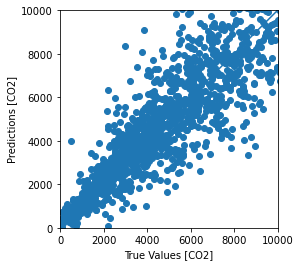

In [25]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [CO2]')
plt.ylabel('Predictions [CO2]')
lims = [0, 10000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)